In [148]:
## imports
import sys, os, random, re, glob
import pandas as pd
import pprint as pp
#from functools import reduce

設定

In [149]:
## 処理設定
verbose = False

### LDA 用
## トピック数
n_topics = 30 # 30は多過ぎる？

## tSNE 用
## 実行前にサンプリングするかどうか
doc_fit_sampling = True

### DTM 構築: doc, term の設定
## doc
doc_type      = 'form'  # 変更不可
doc_attrs     = [ 'spell', 'sound' ]
doc_attr      = doc_attrs[0]
print(f"doc_attr: {doc_attr}")
## term
term_size     = 'character' # 出力用の名目変数
term_types    = re.split(r",\s+", "1gram, 2gram, 3gram, skippy2gram, skippy3gram")
term_type     = term_types[-2]
print(f"term_type: {term_type}")
## doc の長さの上限
max_doc_size  = 13
print(f"max_doc_size: {max_doc_size}")
## doc の長さの下限
min_doc_size  = 4
print(f"min_doc_size: {min_doc_size}")
## term の最低頻度
term_min_freq = 2
## 高頻度 term の濫用指標: 大きくし過ぎないように．terms の異なりが小さいので0.03 は十分に大きい
term_abuse_threshold = 0.005
## skippy n-gram の表記
gap_mark = "…"
## ngram を包括的にするかどうか
ngram_is_inclusive = True
## skippy n-gram の結合範囲
max_distance_val = round(max_doc_size * 0.8)
print(f"max_distance_val: {max_distance_val}")

doc_attr: spell
term_type: skippy2gram
max_doc_size: 13
min_doc_size: 4
max_distance_val: 10


# 言語の選別

In [150]:
## 言語の選別
select_languages = True
## 言語の割合の均等化
balanced = True
## 色分けで言語名の変わりに語族を使う
color_lang_family = False
## 英語をゲルマン語に含める
germanic_includes_english = False
## ルーマニア語をロマンス語に含める
romance_includes_romanian = False
## スラブ語属を設定する
use_slavic = False # russian, czech を一緒にするのは条件付き
## ルーマニア語をスラブ語に含める
slavic_includes_romanian = False


In [151]:
##音声解析で使える言語
## arabic, chinese, english, esperanto, french, german, icelandic, japanese, korean, spanish, swahili

##綴り解析で使える言語
## arabic, bengali, chinese, czech, esperanto, english, finnish, french,
## galician, german, greek, hebrew, hungarian, icelandic, irish, italian,
## japanese, romanian, russian, spanish, swahili, turkish, welsh

import re
## sound sets
sound_set0 = "arabic, chinese, dutch, english, esperato, french, german, icelandic, japanese, korean, spanish, swahili"
sound_set1 = "arabic, dutch, english, esperanto, french, german, icelandic, japanese, korean, spanish, swahili"
#
sound_set_romance = "esperanto, french, galician, spanish"
sound_set_germanic = "english, german, icelandic"
sound_set_semitic = "arabic, hebrew"
sound_set_asian = "chinese, japanese, korean"

## spell sets
spell_set0 = "arabic, bengali, chinese, czech, dutch, esperato, english, finnish, french, \
    galician, german, greek, hebrew, hungarian, icelandic, irish, italian, japanese, korean, \
        romanian, russian, spanish, swahili, turkish, welsh"
spell_set1 = "arabic, czech, hebrew, dutch, english, esperanto, finnish, french, german, greek, \
    hungarian, icelandic, irish, romanian, russian, italian, spanish, swahili, turkish, welsh"
spell_set2 = "dutch, english, esperanto, french, finnish, german, hungarian, icelandic, irish, italian, \
    spanish, swahili, turkish, welsh"
spell_set3 = "dutch, english, esperanto, finnish, german, hungarian, irish, swahili, turkish, welsh"
#
spell_set_celtic     = "irish, welsh"
spell_set_celtic_x   = "irish, welsh, icelandic"
spell_set_germanic   = "dutch, german, icelandic"
spell_set_germanic_x = "dutch, english, german, icelandic"
spell_set_romance    = "esperanto, french, italian, spanish"
spell_set_romance_x  = "esperanto, french, italian, spanish, romanian"
spell_set_slavic     = "czech, russian"

## selection
selected_langs = re.split(r",\s*", spell_set_celtic_x + ", " + "dutch, english, french, german, swahili")
print(f"selected {len(selected_langs)} languages:\n{selected_langs}")

selected 8 languages:
['irish', 'welsh', 'icelandic', 'dutch', 'english', 'french', 'german', 'swahili']


In [152]:
## 全言語をカバーできる色パレットの用意
import plotly
color_palette = plotly.colors.qualitative.Dark24

In [153]:
## load data to process
from pathlib import Path
import pprint as pp
wd = Path(".")
dirs = [ x for x in wd.iterdir() if x.is_dir() and not x.match(r"plot*") ]
if verbose:
    print(f"The following {len(dirs)} directories are potential targets:")
    pp.pprint(dirs)

## list up files in target directory 
target_dir = "data-words" # can be changed
target_files = sorted(list(wd.glob(f"{target_dir}/*.csv")))
print(f"\n{target_dir} contains {len(target_files)} files to process")
if verbose:
    pp.pprint(target_files)


data-words contains 36 files to process


In [154]:
import pandas as pd
## データ型の辞書
types = re.split(r",\s+", "spell, sound")
type_settings = { t : 0 for t in types }
print(type_settings)

## 言語名の辞書
lang_settings = { lang : 0 for lang in selected_langs }
print(f"{len(lang_settings.keys())} langs are targeted")
print(lang_settings)

## 辞書と統合
settings = { **type_settings, **lang_settings }
print(settings)

{'spell': 0, 'sound': 0}
8 langs are targeted
{'irish': 0, 'welsh': 0, 'icelandic': 0, 'dutch': 0, 'english': 0, 'french': 0, 'german': 0, 'swahili': 0}
{'spell': 0, 'sound': 0, 'irish': 0, 'welsh': 0, 'icelandic': 0, 'dutch': 0, 'english': 0, 'french': 0, 'german': 0, 'swahili': 0}


In [155]:
## Obtain data from files
check = False
setting_keys = list(settings.keys())
print(f"target setting_keys: {setting_keys}")
d_parts = [ ]
for lang in lang_settings.keys():
    local_settings = settings.copy()
    if check:
        print(f"processing: {lang}")
    try:
        ## ファイル単位で処理
        for f in [ f for f in target_files if lang.capitalize() in str(f) ]:
            print(f"reading: {f}")
            
            # 言語名の指定
            local_settings[lang] = 1
            
            # 型名の指定
            for key in type_settings.keys():
                if key in str(f):
                    local_settings[key] = 1
                else:
                    local_settings[key] = 0 # この変更を見落とさないように
            
            # ファイル処理
            try:
                data = pd.read_csv(f, encoding = 'utf-8', sep = ",", on_bad_lines = 'skip') # Crucially, ...= skip
                if check:
                    print(data)
                #dfx = pd.DataFrame(data, columns = setting_keys)
                dfx = pd.DataFrame(data, columns = ['form', 'freq'])
                for key in settings.keys():
                    dfx[key] = local_settings[key]
                    if check:
                        print(dfx)
                d_parts.append(dfx)
            except FileNotFoundError:
                pass
    except IndexError:
        pass
#
if verbose:
    d_parts

target setting_keys: ['spell', 'sound', 'irish', 'welsh', 'icelandic', 'dutch', 'english', 'french', 'german', 'swahili']
reading: data-words/base-spell-Irish-r0-1k-mc.csv
reading: data-words/base-spell-Welsh-r0-1k-mc.csv
reading: data-words/base-sound-Icelandic-r0-1k-mc.csv
reading: data-words/base-spell-Icelandic-r0-original.csv
reading: data-words/base-sound-Dutch-r0-1k-mc.csv
reading: data-words/base-spell-Dutch-r0-1k-mc.csv
reading: data-words/base-sound-English-r6e-original.csv
reading: data-words/base-spell-English-r6e-original.csv
reading: data-words/base-sound-French-r0-1k-mc.csv
reading: data-words/base-sound-French-r0-opendic-s900.csv
reading: data-words/base-spell-French-r0-1k-mc.csv
reading: data-words/base-sound-German-r1a-original.csv
reading: data-words/base-spell-German-r1a-original.csv
reading: data-words/base-sound-Swahili-r0-1k-mc.csv
reading: data-words/base-spell-Swahili-r0-1k-mc.csv


In [156]:
## データ統合
raw_df = pd.concat(d_parts)
raw_df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,swahili
0,mar,1.0,1,0,1,0,0,0,0,0,0,0
1,mé,1.0,1,0,1,0,0,0,0,0,0,0
2,a,1.0,1,0,1,0,0,0,0,0,0,0
3,go,1.0,1,0,1,0,0,0,0,0,0,0
4,sé,1.0,1,0,1,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
703,zaidi,1.0,1,0,0,0,0,0,0,0,0,1
704,ziara,1.0,1,0,0,0,0,0,0,0,0,1
705,zima,1.0,1,0,0,0,0,0,0,0,0,1
706,ziwa,1.0,1,0,0,0,0,0,0,0,0,1


In [157]:
## form の小文字化
raw_df[doc_type] = raw_df[doc_type].apply(lambda x: x.lower())

In [158]:
## 言語名= language の列を追加
check = False
language_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    for j, lang in enumerate(selected_langs):
        if check:
            print(f"{i}: {lang}")
        if row[lang] == 1:
            language_vals.append(lang)
if verbose:
    print(language_vals)
    len(language_vals)
#
raw_df['language'] = language_vals
raw_df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,swahili,language
0,mar,1.0,1,0,1,0,0,0,0,0,0,0,irish
1,mé,1.0,1,0,1,0,0,0,0,0,0,0,irish
2,a,1.0,1,0,1,0,0,0,0,0,0,0,irish
3,go,1.0,1,0,1,0,0,0,0,0,0,0,irish
4,sé,1.0,1,0,1,0,0,0,0,0,0,0,irish
...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,zaidi,1.0,1,0,0,0,0,0,0,0,0,1,swahili
704,ziara,1.0,1,0,0,0,0,0,0,0,0,1,swahili
705,zima,1.0,1,0,0,0,0,0,0,0,0,1,swahili
706,ziwa,1.0,1,0,0,0,0,0,0,0,0,1,swahili


In [159]:
## 言語族 family 列の追加
# germanic
if germanic_includes_english:
    germanic_langs = [ 'english', 'dutch', 'german', 'icelandic' ]
else:
    germanic_langs = [ 'dutch', 'german', 'icelandic' ]
# celtic
celtic_langs       = [ 'irish', 'welsh' ]
# romance
if romance_includes_romanian:
    romance_langs  = [ 'esperanto', 'galician', 'french', 'romanian', 'italian', 'spanish' ]
else:
    romance_langs  = [ 'esperanto', 'galician', 'french', 'italian', 'spanish' ]
# slavic
if use_slavic:
    if slavic_includes_romanian:
        slavic_langs   = [ 'czech', 'romanian', 'russian' ]
    else:
        slavic_langs   = [ 'czech', 'russian' ]
else:
    slavic_langs = [ ]
#
check = False
family_vals = [ ]
for i, row in raw_df.iterrows():
    if check:
        print(row)
    lang = row['language']
    if check:
        print(f"{i}: {lang}")
    # romance langs
    if lang in celtic_langs:
        family_vals.append('celtic')
    # romance langs
    elif lang in romance_langs:
        family_vals.append('romance')
    # germanic langs
    elif lang in germanic_langs:
        family_vals.append('germanic')
    # slavic langs
    elif lang in slavic_langs:
        family_vals.append('slavic')
    # all others
    else:
        family_vals.append(lang)
#
if verbose:
    print(family_vals)
    len(family_vals)
#
raw_df['family'] = family_vals
raw_df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,swahili,language,family
0,mar,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic
1,mé,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic
2,a,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic
3,go,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic
4,sé,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,zaidi,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili
704,ziara,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili
705,zima,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili
706,ziwa,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili


In [160]:
## 文字数の列を追加
raw_df['size'] = [ len(x) for x in raw_df[doc_type] ]
raw_df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,swahili,language,family,size
0,mar,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,3
1,mé,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,2
2,a,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,1
3,go,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,2
4,sé,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,zaidi,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,5
704,ziara,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,5
705,zima,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,4
706,ziwa,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,4


In [161]:
## 解析データの型指定
print(f"doc_attr: {doc_attr}")
raw_df = raw_df[raw_df[doc_attr] == 1]
raw_df

doc_attr: spell


,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,swahili,language,family,size
0,mar,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,3
1,mé,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,2
2,a,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,1
3,go,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,2
4,sé,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,zaidi,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,5
704,ziara,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,5
705,zima,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,4
706,ziwa,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,4


In [162]:
## 言語の選別
if select_languages:
    df_new = [ ]
    for lang in selected_langs:
        df_new.append(raw_df[raw_df[lang] == 1])
    raw_df = pd.concat(df_new)
#
raw_df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,swahili,language,family,size
0,mar,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,3
1,mé,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,2
2,a,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,1
3,go,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,2
4,sé,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,zaidi,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,5
704,ziara,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,5
705,zima,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,4
706,ziwa,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,4


/var/folders/7s/_syxn0dd45lcngw4yl2kywd40000gn/T/ipykernel_37695/1424494094.py:10: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



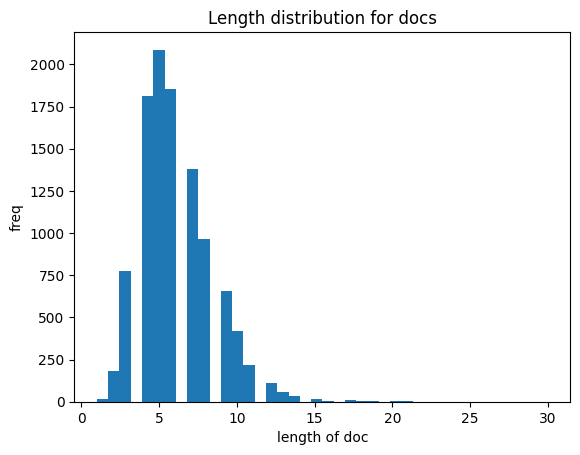

In [163]:
## 文字数の分布
import numpy as np
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(raw_df['size'], bins = 40)
ax.set_xlabel('length of doc')
ax.set_ylabel('freq')
plt.title(f"Length distribution for docs")
fig.show()

データを長さで濾過

In [164]:
## 長過ぎる語の除外 
print(f"max doc size: {max_doc_size}")
original_size = len(raw_df)
raw_df = raw_df[raw_df['size'] <= max_doc_size]
max_filtered_size = len(raw_df)
print(f"{original_size - max_filtered_size} cases removed due to max_doc_size")

## 短過ぎる語の除外
print(f"min doc size: {min_doc_size}")
raw_df = raw_df[raw_df['size'] >= min_doc_size]
min_filtered_size = len(raw_df)
print(f"{max_filtered_size - min_filtered_size} cases removed due to min_doc_size")
#
print(f"{original_size - min_filtered_size} cases removed in total")

max doc size: 13
85 cases removed due to max_doc_size
min doc size: 4
976 cases removed due to min_doc_size
1061 cases removed in total


In [165]:
## 結果の検査 1
for type in types:
    print(raw_df[type].value_counts(sort = True))

spell
1    9567
Name: count, dtype: int64
sound
0    9567
Name: count, dtype: int64


In [166]:
## 結果の検査 2
for lang in selected_langs:
    print(raw_df[lang].value_counts(sort = True).sort_index())

irish
0    8722
1     845
Name: count, dtype: int64
welsh
0    8717
1     850
Name: count, dtype: int64
icelandic
0    8827
1     740
Name: count, dtype: int64
dutch
0    8702
1     865
Name: count, dtype: int64
english
0    5569
1    3998
Name: count, dtype: int64
french
0    8691
1     876
Name: count, dtype: int64
german
0    8849
1     718
Name: count, dtype: int64
swahili
0    8892
1     675
Name: count, dtype: int64


英語事例の割合補正

In [167]:
## 統合: 割合補正を適用
eng_reduct_factor = 0.2
if balanced:
    try:
        eng_df = raw_df[raw_df['english'] == 1]
        non_eng_df = raw_df[raw_df['english'] == 0]
        eng_reduced_df = eng_df.sample(round(len(eng_df) * eng_reduct_factor))
        raw_df = pd.concat([eng_reduced_df, non_eng_df])
    except KeyError:
        pass
#
raw_df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,swahili,language,family,size
251,awake,1.0,1,0,0,0,0,0,1,0,0,0,english,english,5
2860,polyurethane,1.0,1,0,0,0,0,0,1,0,0,0,english,english,12
2828,player,1.0,1,0,0,0,0,0,1,0,0,0,english,english,6
551,cattle,1.0,1,0,0,0,0,0,1,0,0,0,english,english,6
2398,months,1.0,1,0,0,0,0,0,1,0,0,0,english,english,6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703,zaidi,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,5
704,ziara,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,5
705,zima,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,4
706,ziwa,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,4


In [168]:
## 結果の検査 3
for lang in selected_langs:
    print(raw_df[lang].value_counts().sort_index())

irish
0    5524
1     845
Name: count, dtype: int64
welsh
0    5519
1     850
Name: count, dtype: int64
icelandic
0    5629
1     740
Name: count, dtype: int64
dutch
0    5504
1     865
Name: count, dtype: int64
english
0    5569
1     800
Name: count, dtype: int64
french
0    5493
1     876
Name: count, dtype: int64
german
0    5651
1     718
Name: count, dtype: int64
swahili
0    5694
1     675
Name: count, dtype: int64


# 解析

In [169]:
## 順序のランダマイズし，基本データを決定
import sklearn.utils
df = sklearn.utils.shuffle(raw_df)

DTM 構築の準備

In [170]:
## ngram の追加
import sys
sys.path.append('..')

import re
import ngrams
import importlib
importlib.reload(ngrams)
import ngrams_skippy

# name the shared variable
bases = df[doc_type]

In [171]:
## 1gram 列の追加
unigrams = ngrams.gen_unigrams(bases, sep = r"", check = False)
unigrams = [ [ u for u in L if len(u) > 0 ] for L in unigrams ]
if verbose:
    random.sample(unigrams, 5)
#
df['1gram'] = unigrams
df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,swahili,language,family,size,1gram
643,llif,1.0,1,0,0,1,0,0,0,0,0,0,welsh,celtic,4,"[l, l, i, f]"
167,kadhaa,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,6,"[k, a, d, h, a, a]"
28,angalau,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,7,"[a, n, g, a, l, a, u]"
454,le linn,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,7,"[l, e, , l, i, n, n]"
554,beide,1.0,1,0,0,0,0,0,0,0,1,0,german,germanic,5,"[b, e, i, d, e]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,ráðast,1.0,1,0,0,0,1,0,0,0,0,0,icelandic,germanic,6,"[r, á, ð, a, s, t]"
3083,reduce,1.0,1,0,0,0,0,0,1,0,0,0,english,english,6,"[r, e, d, u, c, e]"
299,tweede,1.0,1,0,0,0,0,1,0,0,0,0,dutch,germanic,6,"[t, w, e, e, d, e]"
207,réponse,1.0,1,0,0,0,0,0,0,1,0,0,french,romance,7,"[r, é, p, o, n, s, e]"


In [172]:
## 2gram列の追加
bigrams = ngrams.gen_bigrams(bases, sep = r"", check = False)

## 包括的 2gram の作成
if ngram_is_inclusive:
    bigrams = [ [*b, *u] for b, u in zip(bigrams, unigrams) ]
#
if verbose:
    print(random.sample(bigrams, 3))

In [173]:
df['2gram'] = bigrams
if verbose:
    df

In [174]:
## 3gram列の追加
trigrams = ngrams.gen_trigrams(bases, sep = r"", check = False)

## 包括的 3gram の作成
if ngram_is_inclusive:
    trigrams = [ [ *t, *b ] for t, b in  zip(trigrams, bigrams) ]
#
if verbose:
    print(random.sample(trigrams, 3))

In [175]:
df['3gram'] = trigrams
if verbose:
    df

In [176]:
## skippy 2grams の生成
import ngrams_skippy
skippy_2grams = [ ngrams_skippy.gen_skippy_bigrams(x, missing_mark = gap_mark,
                                                    max_distance = max_distance_val, check = False)
                  for x in df['1gram'] ]

## 包括的 skippy 2-grams の生成
if ngram_is_inclusive:
    for i, b2 in enumerate(skippy_2grams):
        b2.extend(unigrams[i])
#
if verbose:
    random.sample(skippy_2grams, 3)

In [177]:
## skippy 2gram 列の追加
df['skippy2gram'] = skippy_2grams
df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,swahili,language,family,size,1gram,2gram,3gram,skippy2gram
643,llif,1.0,1,0,0,1,0,0,0,0,0,0,welsh,celtic,4,"[l, l, i, f]","[ll, li, if, l, l, i, f]","[lli, lif, ll, li, if, l, l, i, f]","[ll, l…i, l…f, li, if, l, l, i, f]"
167,kadhaa,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,6,"[k, a, d, h, a, a]","[ka, ad, dh, ha, aa, k, a, d, h, a, a]","[kad, adh, dha, haa, ka, ad, dh, ha, aa, k, a,...","[ka, k…d, k…h, k…a, ad, a…h, a…a, dh, d…a, ha,..."
28,angalau,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,7,"[a, n, g, a, l, a, u]","[an, ng, ga, al, la, au, a, n, g, a, l, a, u]","[ang, nga, gal, ala, lau, an, ng, ga, al, la, ...","[an, a…g, a…a, a…l, a…u, ng, n…a, n…l, n…u, ga..."
454,le linn,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,7,"[l, e, , l, i, n, n]","[le, e , l, li, in, nn, l, e, , l, i, n, n]","[le , e l, li, lin, inn, le, e , l, li, in, ...","[le, l… , l…l, l…i, l…n, e , e…l, e…i, e…n, l..."
554,beide,1.0,1,0,0,0,0,0,0,0,1,0,german,germanic,5,"[b, e, i, d, e]","[be, ei, id, de, b, e, i, d, e]","[bei, eid, ide, be, ei, id, de, b, e, i, d, e]","[be, b…i, b…d, b…e, ei, e…d, e…e, id, i…e, de,..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,ráðast,1.0,1,0,0,0,1,0,0,0,0,0,icelandic,germanic,6,"[r, á, ð, a, s, t]","[rá, áð, ða, as, st, r, á, ð, a, s, t]","[ráð, áða, ðas, ast, rá, áð, ða, as, st, r, á,...","[rá, r…ð, r…a, r…s, r…t, áð, á…a, á…s, á…t, ða..."
3083,reduce,1.0,1,0,0,0,0,0,1,0,0,0,english,english,6,"[r, e, d, u, c, e]","[re, ed, du, uc, ce, r, e, d, u, c, e]","[red, edu, duc, uce, re, ed, du, uc, ce, r, e,...","[re, r…d, r…u, r…c, r…e, ed, e…u, e…c, e…e, du..."
299,tweede,1.0,1,0,0,0,0,1,0,0,0,0,dutch,germanic,6,"[t, w, e, e, d, e]","[tw, we, ee, ed, de, t, w, e, e, d, e]","[twe, wee, eed, ede, tw, we, ee, ed, de, t, w,...","[tw, t…e, t…d, we, w…e, w…d, ee, e…d, e…e, ed,..."
207,réponse,1.0,1,0,0,0,0,0,0,1,0,0,french,romance,7,"[r, é, p, o, n, s, e]","[ré, ép, po, on, ns, se, r, é, p, o, n, s, e]","[rép, épo, pon, ons, nse, ré, ép, po, on, ns, ...","[ré, r…p, r…o, r…n, r…s, r…e, ép, é…o, é…n, é…..."


In [178]:
## skippy 3grams の生成
import ngrams_skippy
skippy_3grams = [ ngrams_skippy.gen_skippy_trigrams(x, missing_mark = gap_mark,
                                                         max_distance = max_distance_val, check = False)
                  for x in df['1gram'] ]

## 包括的 skippy 3-grams の生成
if ngram_is_inclusive:
    for i, t2 in enumerate(skippy_3grams):
        t2.extend(skippy_2grams[i])
#
if verbose:
    random.sample(skippy_3grams, 3)

In [179]:
## skippy 3gram 列の追加
df['skippy3gram'] = skippy_3grams
df

,form,freq,spell,sound,irish,welsh,icelandic,dutch,english,french,german,swahili,language,family,size,1gram,2gram,3gram,skippy2gram,skippy3gram
643,llif,1.0,1,0,0,1,0,0,0,0,0,0,welsh,celtic,4,"[l, l, i, f]","[ll, li, if, l, l, i, f]","[lli, lif, ll, li, if, l, l, i, f]","[ll, l…i, l…f, li, if, l, l, i, f]","[lli, ll…f, l…if, lif, ll, l…i, l…f, li, if, l..."
167,kadhaa,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,6,"[k, a, d, h, a, a]","[ka, ad, dh, ha, aa, k, a, d, h, a, a]","[kad, adh, dha, haa, ka, ad, dh, ha, aa, k, a,...","[ka, k…d, k…h, k…a, ad, a…h, a…a, dh, d…a, ha,...","[kad, ka…h, ka…a, k…dh, k…d…a, k…ha, k…h…a, k…..."
28,angalau,1.0,1,0,0,0,0,0,0,0,0,1,swahili,swahili,7,"[a, n, g, a, l, a, u]","[an, ng, ga, al, la, au, a, n, g, a, l, a, u]","[ang, nga, gal, ala, lau, an, ng, ga, al, la, ...","[an, a…g, a…a, a…l, a…u, ng, n…a, n…l, n…u, ga...","[ang, an…a, an…l, an…u, a…ga, a…g…l, a…g…a, a…..."
454,le linn,1.0,1,0,1,0,0,0,0,0,0,0,irish,celtic,7,"[l, e, , l, i, n, n]","[le, e , l, li, in, nn, l, e, , l, i, n, n]","[le , e l, li, lin, inn, le, e , l, li, in, ...","[le, l… , l…l, l…i, l…n, e , e…l, e…i, e…n, l...","[le , le…l, le…i, le…n, l… l, l… …i, l… …n, l…..."
554,beide,1.0,1,0,0,0,0,0,0,0,1,0,german,germanic,5,"[b, e, i, d, e]","[be, ei, id, de, b, e, i, d, e]","[bei, eid, ide, be, ei, id, de, b, e, i, d, e]","[be, b…i, b…d, b…e, ei, e…d, e…e, id, i…e, de,...","[bei, be…d, be…e, b…id, b…i…e, b…de, eid, ei…e..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
564,ráðast,1.0,1,0,0,0,1,0,0,0,0,0,icelandic,germanic,6,"[r, á, ð, a, s, t]","[rá, áð, ða, as, st, r, á, ð, a, s, t]","[ráð, áða, ðas, ast, rá, áð, ða, as, st, r, á,...","[rá, r…ð, r…a, r…s, r…t, áð, á…a, á…s, á…t, ða...","[ráð, rá…a, rá…s, rá…t, r…ða, r…ð…s, r…ð…t, r…..."
3083,reduce,1.0,1,0,0,0,0,0,1,0,0,0,english,english,6,"[r, e, d, u, c, e]","[re, ed, du, uc, ce, r, e, d, u, c, e]","[red, edu, duc, uce, re, ed, du, uc, ce, r, e,...","[re, r…d, r…u, r…c, r…e, ed, e…u, e…c, e…e, du...","[red, re…u, re…c, re…e, r…du, r…d…c, r…d…e, r…..."
299,tweede,1.0,1,0,0,0,0,1,0,0,0,0,dutch,germanic,6,"[t, w, e, e, d, e]","[tw, we, ee, ed, de, t, w, e, e, d, e]","[twe, wee, eed, ede, tw, we, ee, ed, de, t, w,...","[tw, t…e, t…d, we, w…e, w…d, ee, e…d, e…e, ed,...","[twe, tw…e, tw…d, t…ee, t…e…d, t…e…e, t…ed, t…..."
207,réponse,1.0,1,0,0,0,0,0,0,1,0,0,french,romance,7,"[r, é, p, o, n, s, e]","[ré, ép, po, on, ns, se, r, é, p, o, n, s, e]","[rép, épo, pon, ons, nse, ré, ép, po, on, ns, ...","[ré, r…p, r…o, r…n, r…s, r…e, ép, é…o, é…n, é…...","[rép, ré…o, ré…n, ré…s, ré…e, r…po, r…p…n, r…p..."


DTM 構築

In [180]:
## LDA 構築の基になる document-term matrix (dtm) を構築
from gensim.corpora.dictionary import Dictionary
bots = df[term_type] # 後で参照するので変数化しておく
diction = Dictionary(bots)

## 結果の確認
print(diction)

Dictionary<2528 unique tokens: ['f', 'i', 'if', 'l', 'li']...>


In [181]:
## diction の濾過
import copy
diction_copy = copy.deepcopy(diction)

## filter適用: 実は諸刃の刃で，token数が少ない時には適用しない方が良い
print(f"min freq filter: {term_min_freq}")
print(f"abuse filter: {term_abuse_threshold}")

apply_filter = True
if apply_filter:
    diction_copy.filter_extremes(no_below = term_min_freq, no_above = term_abuse_threshold)

## check
print(diction_copy)

min freq filter: 2
abuse filter: 0.005
Dictionary<1329 unique tokens: [' l', 'e ', 'l… ', 'jö', 'j…ð']...>


In [182]:
## Corpus (gensim の用語では corpus) の構築
corpus = [ diction.doc2bow(bot) for bot in bots ]

## check
check = True
if verbose:
    sample_n = 5
    print(random.sample(corpus, sample_n))
#
print(f"Number of documents: {len(corpus)}")

Number of documents: 6369


LDA モデルの構築

In [183]:
## LDA モデルの構築
from gensim.models import LdaModel
print(f"Building LDA model with n_topics: {n_topics}")
lda = LdaModel(corpus, id2word = diction, num_topics = n_topics, alpha = 0.01)
print(lda) # print(..)しないと中身が見れない

Building LDA model with n_topics: 30
LdaModel<num_terms=2528, num_topics=30, decay=0.5, chunksize=2000>


In [184]:
%%capture --no-display

## LDA のtopic ごとに，関連度の高い term を表示
import pandas as pd
n_terms = 30 # topic ごとに表示する term 数の指定
topic_dfs = [ ]
for topic in range(n_topics):
    terms = [ ]
    for i, prob in lda.get_topic_terms(topic, topn = n_terms):
        terms.append(diction.id2token[ int(i) ])
    #
    topic_dfs.append(pd.DataFrame([terms], index = [ f'topic {topic+1}' ]))
#
topic_term_df = pd.concat(topic_dfs)

## Table で表示
topic_term_df.T

,topic 1,topic 2,topic 3,topic 4,topic 5,topic 6,topic 7,topic 8,topic 9,topic 10,...,topic 21,topic 22,topic 23,topic 24,topic 25,topic 26,topic 27,topic 28,topic 29,topic 30
0,e,f,e,a,n,r,b,n,o,k,...,e,n,a,i,y,n,l,u,o,s
1,n,r,l,l,g,o,l,a,i,a,...,r,t,h,t,l,a,s,n,t,i
2,i,a,v,t,a,n,b…i,a…n,o…i,k…a,...,r…e,r,t,h,n,d,h,un,o…t,u
3,c,f…r,i,y,i,or,e,e,m,u,...,t,e,ha,a,d,an,f,e,oo,t
4,en,f…a,d,ta,a…n,o…n,r,v,d,ku,...,h,i,m,t…i,w,o,se,u…e,o…o,r
5,e…e,f…e,e…e,s,t,o…e,o,an,s,u…a,...,re,t…n,a…a,e,i,n…o,e,m,r,s…i
6,e…n,fa,e…l,t…l,an,o…r,b…e,v…a,on,b,...,er,r…n,a…h,i…i,f…y,a…o,o,n…u,or,u…i
7,i…e,f…i,o,al,a…g,p,be,na,n,ka,...,e…e,e…t,h…a,n,yn,s,ef,u…d,t…o,is
8,c…e,ar,v…e,l…a,g…n,d,b…n,a…e,i…o,k…e,...,he,n…r,c…a,r,wy,k…n,s…l,d,to,s…r
9,n…e,f…h,el,e,ng,e,s,en,h,t,...,e…r,e…r,p,i…h,y…d,w,s…f,m…n,o…a,st


LDAvis の実行

In [185]:
%%capture --no-display

## pyLDAvis を使った結果 LDA の可視化: 階層クラスタリングより詳しい
import pyLDAvis
installed_version = pyLDAvis.__version__
print(f"installed_version: {installed_version}")
if float(installed_version[:3]) > 3.1:
    import pyLDAvis.gensim_models as gensimvis
else:
    import pyLDAvis.gensim as gensimvis
#
pyLDAvis.enable_notebook()
#
lda_used     = lda
corpus_used  = corpus
diction_used = diction

## 実行パラメター: MMDS かtSNEを選ぶと "JSON object is too complex" error を回避できる 
use_MMDS  = True
use_tSNE  = False
if use_MMDS:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'mmds',
                            n_jobs = 1, sort_topics = False)
elif use_tSNE:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used, mds = 'tsne',
                            n_jobs = 1, sort_topics = False)
else:
    vis = gensimvis.prepare(lda_used, corpus_used, diction_used,
                            n_jobs = 1, sort_topics = False)
#
pyLDAvis.display(vis)
## topic を表わす円の重なりが多いならn_topics が多過ぎる可能性がある．
## ただし2Dで重なっていても，3Dなら重なっていない可能性もある

In [186]:
## LDA がD に対して生成した topics の弁別性を確認
## 得られたtopics を確認
topic_dist = lda.get_topics()
if verbose:
    topic_dist

In [187]:
## 検査 1: topic ごとに分布の和を取る
print(topic_dist.sum(axis = 1))

[0.99999994 0.9999999  0.99999994 0.99999994 1.         1.0000001
 1.         1.0000001  0.99999994 1.         1.         1.
 1.         1.         0.99999994 1.         1.         1.
 1.0000001  1.0000001  1.         1.         1.         1.
 0.9999999  1.0000001  1.         1.0000001  0.9999999  1.        ]


In [188]:
## 検査 2: 総和を求める: n_topics にほぼ等しいなら正常
print(topic_dist.sum())

29.999998


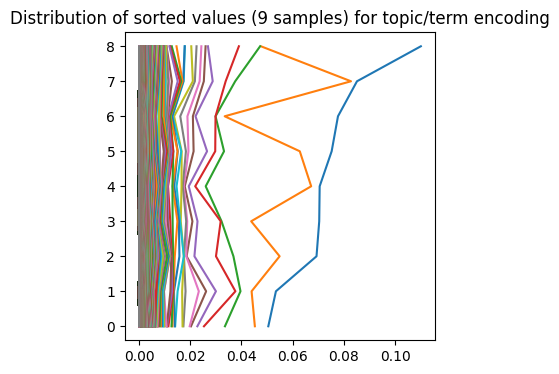

In [189]:
## term エンコード値の分布を確認
import matplotlib.pyplot as plt
plt.figure(figsize = (4,4))
sampling_rate = 0.3
df_size = len(topic_dist)
sample_n = round(df_size * sampling_rate)
topic_sampled = random.sample(list(topic_dist), sample_n)

T = sorted([ sorted(x, reverse = True) for x in topic_sampled ])
plt.plot(T, range(len(T)))
plt.title(f"Distribution of sorted values ({sample_n} samples) for topic/term encoding")
plt.show()

In [190]:
## tSNE を使った topics のグループ化 (3D)
from sklearn.manifold import TSNE
import numpy as np

## tSNE のパラメターを設定
## n_components は射影先の空間の次元: n_components = 3 なら3次元空間に射影
top_perplexity_reduct_rate = 0.3
perplexity_val = round(len(topic_dist) * top_perplexity_reduct_rate)
topic_tSNE_3d = TSNE(n_components = 3, random_state = 0, perplexity = perplexity_val, n_iter = 1000)

## データに適用
top_tSNE_3d_fitted = topic_tSNE_3d.fit_transform(np.array(topic_dist))

In [191]:
## Plotlyを使って tSNE の結果の可視化 (3D)
import plotly.graph_objects as go
top_fitted = top_tSNE_3d_fitted
fig = go.Figure(data = [go.Scatter3d(
        x = top_fitted[:,0], y = top_fitted[:,1], z = top_fitted[:,2],
                                     mode = 'markers')
                                     ])

## 3D 散布図にラベルを追加する処理は未実装
title_val = f"tSNE 3D view of topics in LDA (#topics: {n_topics}, doc: {doc_attr}, term: {term_type})"
fig.update_layout(autosize = False,
                  width = 600, height = 600, title = title_val)
fig.show()

# doc 分類

In [192]:
## 構築した LDA モデルを使って文(書)を分類する

## パラメター
ntopics = n_topics # LDA の構築の最に指定した値を使う
check    = False
encoding = [ ]
for i, row in df.iterrows():
    if check:
        print(f"row: {row}")
    doc = row[doc_type]
    bot = row[term_type]
    ## get_document_topics(..) では　minimu_probability = 0 としないと
    ## 値が十分に大きな topics に関してだけ値が取れる
    enc = lda.get_document_topics(diction.doc2bow(bot), minimum_probability = 0)
    if check:
        print(f"enc: {enc}")
    encoding.append(enc)
#
len(encoding)

6369

In [193]:
## enc 列の追加
df['enc'] = [ list(map(lambda x: x[1], y)) for y in encoding ]
if verbose:
    df['enc']

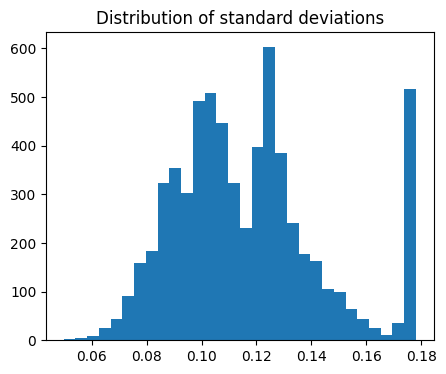

In [194]:
## エンコーディングのstd の分布を見る
import numpy as np
from matplotlib import pyplot as plt

plt.figure(figsize = (5,4))
plt.hist([ np.std(x) for x in df['enc'] ], bins = 30)

plt.title("Distribution of standard deviations")
plt.show()

In [195]:
## doc のエンコーディング

## 一様分布の事例を除外
import numpy as np
print(f"{len(df)} instances before filtering")

check = False
doc_enc = df['enc']
max_std = max([ np.std(x) for x in doc_enc])
if check:
    print(f"std max: {max_std}")

min_std = min([ np.std(x) for x in doc_enc])
if check:
    print(f"std min: {min_std}")

first_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-0]
print(f"std 1st min: {first_min_std}")

second_min_std = list(sorted(set([ np.std(x) for x in doc_enc])))[-1]
print(f"std 2nd min: {second_min_std}")

6369 instances before filtering
std 1st min: 0.04979132488369942
std 2nd min: 0.17813511192798615


In [196]:
## df_filtered の定義
import numpy as np

## 閾値は2番目に小さい値より小さく最小値よりは大きな値であるべき
std_threshold = second_min_std / 4 # 穏健な値を得るために4で割った
print(f"std_threshold: {std_threshold}")

## Rっぽい次のコードは通らない
#df_filtered = df[ df['encoding'] > std_threshold ]
## 通るのは次のコード: Creating a list of True/False and apply it to DataFrame 
std_tested = [ False if np.std(x) < std_threshold else True for x in df['enc'] ]
df_filtered = df[ std_tested ]
#
print(f"Filtering leaves {len(df_filtered)} instances: ({len(df) - len(df_filtered)} instances removed)")

std_threshold: 0.044533777981996536
Filtering leaves 6369 instances: (0 instances removed)


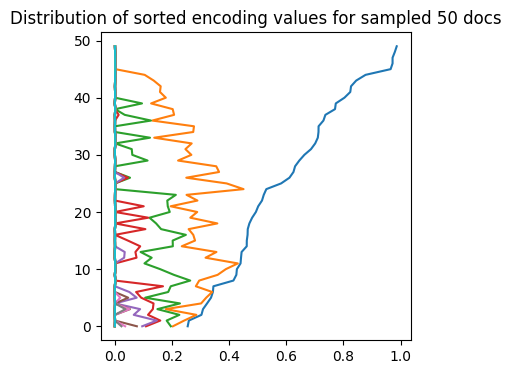

In [197]:
## doc エンコード値の分布を確認
sample_n = 50
E = sorted([ sorted(x, reverse = True) for x in df_filtered['enc'].sample(sample_n) ])
plt.figure(figsize = (4,4))
plt.plot(E, range(len(E)))
plt.title(f"Distribution of sorted encoding values for sampled {sample_n} docs")
plt.show()

In [198]:
len(df_filtered['language'])

6369

In [199]:
df_filtered['language'].value_counts(sort = True).sort_index()

language
dutch        865
english      800
french       876
german       718
icelandic    740
irish        845
swahili      675
welsh        850
Name: count, dtype: int64

tSNE 用の事例サンプリング

In [200]:
## tSNE 用の事例サンプリング = tSNE_df の定義
doc_fit_sampling_rate = 0.15
if doc_fit_sampling:
    doc_fit_df_original = df_filtered.copy()
    sample_n = round(len(doc_fit_df_original) * doc_fit_sampling_rate)
    doc_fit_df = doc_fit_df_original.sample(sample_n)
    print(f"doc_fit_df has {len(doc_fit_df)} rows after sampling")
else:
    doc_fit_df = df_filtered

doc_fit_df has 955 rows after sampling


In [201]:
doc_fit_df.columns

Index(['form', 'freq', 'spell', 'sound', 'irish', 'welsh', 'icelandic',
       'dutch', 'english', 'french', 'german', 'swahili', 'language', 'family',
       'size', '1gram', '2gram', '3gram', 'skippy2gram', 'skippy3gram', 'enc'],
      dtype='object')

In [202]:
doc_fit_df['language'].value_counts(sort = True).sort_index()

language
dutch        115
english      133
french       138
german       119
icelandic    114
irish        118
swahili       92
welsh        126
Name: count, dtype: int64

In [203]:
doc_fit_df['family'].value_counts(sort = True).sort_index()

family
celtic      244
english     133
germanic    348
romance     138
swahili      92
Name: count, dtype: int64

tSNE の結果の可視化 (3D)

In [204]:
## tSNE の結果の可視化: Plotly を使った 3D 描画
import numpy as np
from sklearn.manifold import TSNE as tSNE

import plotly.express as pex
import plotly.graph_objects as go
import matplotlib.pyplot as plt

## tSNE のパラメターを設定
perplexity_max_val = round(len(doc_fit_df)/4)
print(f"perplexity_max_val: {perplexity_max_val}")
#perplexity_increment = 120
divider = 5
perplexity_increment = round(perplexity_max_val/divider)
print(f"perplexity_increment: {perplexity_increment}")

## tSNE を段階的に実行
early_exit = False
for step, perplexity_val in enumerate(range(5, perplexity_max_val, perplexity_increment)):
    ## 早期終了の判定
    if early_exit:
        if step > 0:
            continue
    ## tSNE 事例の生成
    tSNE_3d_varied = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_val,
                          n_iter = 1000)

    ## データに適用
    doc_enc = np.array(list(doc_fit_df['enc']))
    doc_tSNE_3d_varied = tSNE_3d_varied.fit_transform(doc_enc)

    ## 色分けの単位を選択
    if color_lang_family:
        colored_var = 'family'
    else:
        colored_var = 'language'
    T = zip(doc_tSNE_3d_varied[:,0], doc_tSNE_3d_varied[:,1], doc_tSNE_3d_varied[:,2],
            doc_fit_df[colored_var]) # zip(..)が必要
    dfx = pd.DataFrame(T, columns = ['D1', 'D2', 'D3', colored_var])
    ## 作図
    fig = go.Figure()
    for lang in np.unique(df[colored_var]):
        part = dfx[dfx[colored_var] == lang]
        fig.add_trace(
            go.Scatter3d(
                x = part['D1'], y = part['D2'], z = part['D3'],
                name = lang, mode = 'markers', marker = dict(size = 4),
                marker_colorscale = color_palette, # worked??
                showlegend = True
            )
        )
    ## 題の指定
    title_val = f"tSNE 3D map (ppl: {perplexity_val}) of {len(doc_fit_df)} '{doc_attr}'s via LDA ({n_topics} topics, {term_type})"
    fig.update_layout(title = dict(text = title_val),
                      autosize = False, width = 600, height = 600)
    fig.show()

perplexity_max_val: 239
perplexity_increment: 48


In [205]:
## 必要に応じて adjustText を道入
#!pip install -U adjustText

tSNE の結果の可視化 (2D)

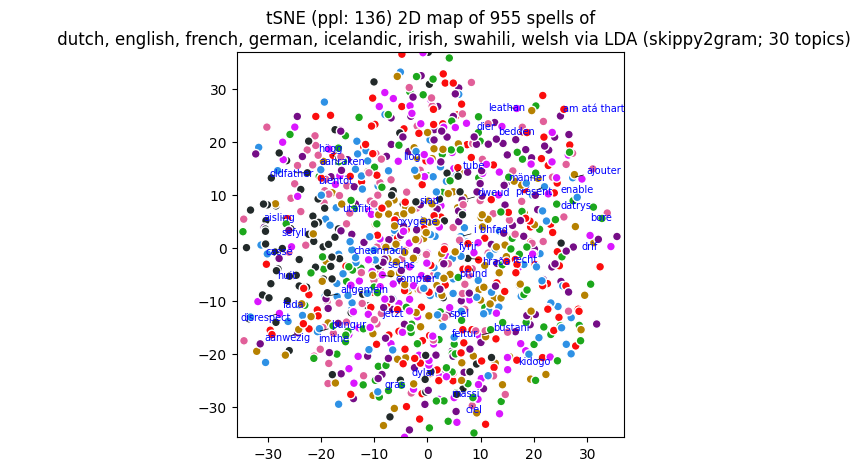

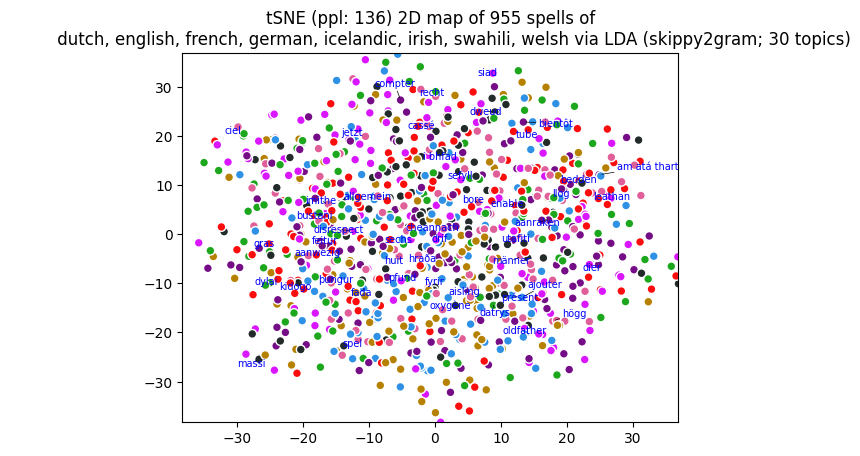

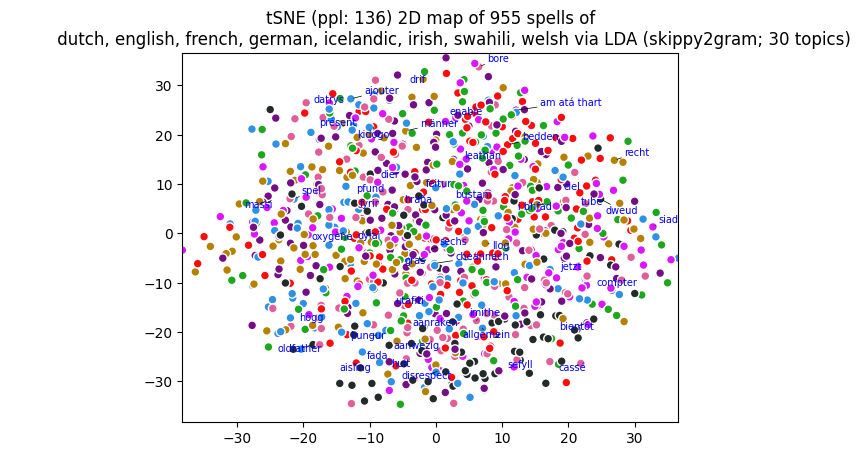

In [206]:
## tSNE の結果の可視化 (2D)
#import seaborn as sns
import numpy as np
import plotly
import plotly.express as pex
import matplotlib.pyplot as plt
from adjustText import adjust_text

## 次の設定は arabic が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある

## tSNE 事例の生成
ppl_divider = 7
perplexity_selected = round(len(doc_fit_df)/ppl_divider)
tSNE_3d = tSNE(n_components = 3, random_state = 0, perplexity = perplexity_selected, n_iter = 1000)

## データに適用
doc_enc = np.array(list(doc_fit_df['enc']))
doc_tSNE_3d = tSNE_3d.fit_transform(doc_enc)

## 色分けの単位を選択
if color_lang_family:
    colored_var = 'family' # 一部の言語を celtic, germanic, romance, slavic 属に統合
else:
    colored_var = 'language' # 言語名そのまま
#
S = zip(doc_tSNE_3d[:,0], doc_tSNE_3d[:,1], doc_tSNE_3d[:,2], doc_fit_df[colored_var]) # zip(..)が必要
df = pd.DataFrame(S, columns = ['D1', 'D2', 'D3', colored_var])

## 描画
plt.figure(figsize = (5, 5))
plt.set_colors = pex.colors.qualitative.Plotly
#
lab_sampling_rate = 0.05
lab_sample_n = round(len(doc_fit_df) * lab_sampling_rate)
sampled_keys = [ doc[:max_doc_size] for doc in random.sample(list(doc_fit_df[doc_type]), lab_sample_n) ]    

check = False
early_exit = False
for step, roll in enumerate([ np.roll([0,1,2], -i) for i in range(0,3) ]):
    ## 早期停止の判定
    if early_exit:
        if step > 0:
            continue
    ## 通常処理
    if check:
        print(roll)
    X, Y = df.iloc[:, roll[0]], df.iloc[:, roll[1]]
    gmax = max(X.max(), Y.max())
    gmin = min(X.min(), Y.min())
    plt.xlim(gmin, gmax)
    plt.ylim(gmin, gmax)

    ## 配色
    colormap = color_palette # == pex.colors.qualitative.Light24
    lang_list = list(set(doc_fit_df[colored_var]))
    cmapped = [ colormap[lang_list.index(lang)] for lang in df[colored_var] ]
    
    ## 作図
    scatter = plt.scatter(X, Y, s = 40, c = cmapped, edgecolors = 'w')

    ## 文字を表示する事例のサンプリング
    texts = [ ]
    ## labels の生成
    for x, y, s in zip(X, Y, sampled_keys):
        texts.append(plt.text(x, y, s, size = 7, color = 'blue'))
        ## label に repel を追加: adjustText package の導入が必要
    adjust_text(texts,
        #force_points = 0.2,
        ## Comment out the following line if you get AttributionError
        #force_text = (.1, .2), expand_points = (1, 1), expand_text = (1, 1),
        arrowprops = dict(arrowstyle = "-", color = 'black', lw = 0.5))
    #
    plt.title(f"tSNE (ppl: {perplexity_selected}) 2D map of {len(doc_fit_df)} {doc_attr}s of\n \
        {', '.join(sorted(selected_langs))} via LDA ({term_type}; {n_topics} topics)")
    #plt.legend(df['language'])
    plt.show()

階層クラスタリングのための部分サンプリングの追加

In [207]:
## 階層クラスタリングのための事例のサンプリング
hc_sampling_rate = 0.15 # 大きくし過ぎると図が見にくい
df_size = len(doc_fit_df)
hc_sample_n = round(df_size * hc_sampling_rate)
doc_hc_df = doc_fit_df.sample(hc_sample_n)
##
print(f"{hc_sample_n} rows are sampled")
doc_hc_df[colored_var].value_counts(sort = True).sort_index()

143 rows are sampled


language
dutch        17
english      18
french       26
german       18
icelandic    15
irish        16
swahili      15
welsh        18
Name: count, dtype: int64

階層クラスタリングの実行

/Users/kowk/opt/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning:

Glyph 9 (	) missing from current font.



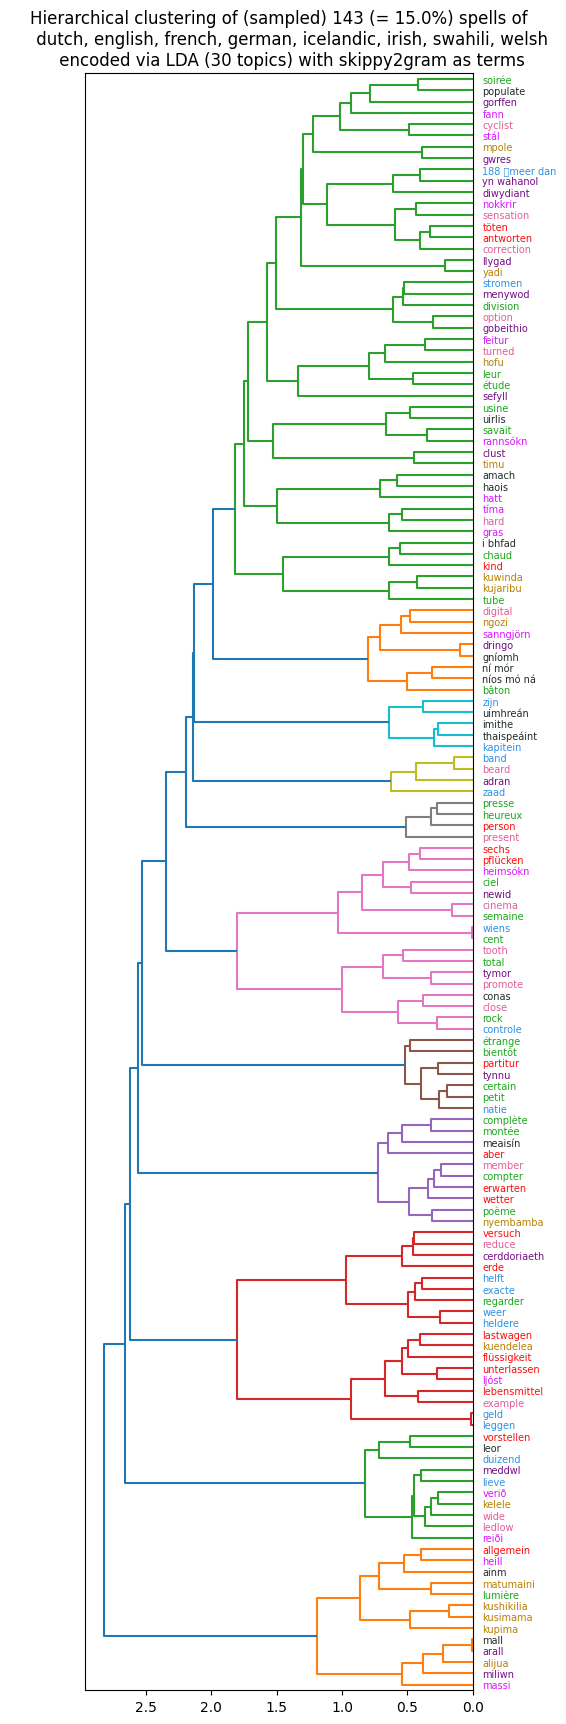

In [208]:
## doc 階層クラスタリングの実行
import numpy as np
import plotly
import matplotlib.pyplot as plt
## 次の設定は arabic, bengali が文字化けする
#plt.rcParams["font.family"] = "Hiragino Sans" # Windows は別のフォント名を指定する必要がある

## 描画サイズの指定
plt.figure(figsize = (5, round(len(doc_hc_df) * 0.15))) # This needs to be run here, before dendrogram construction.

## 事例ラベルの生成
label_vals = [ x[:max_doc_size] for x in list(doc_hc_df[doc_type]) ] # truncate doc keys

## 樹状分岐図の作成
from scipy.cluster.hierarchy import dendrogram, linkage

## 距離行列の生成
doc_hc_enc = list(doc_hc_df['enc'])
doc_linkage = linkage(doc_hc_enc, method = 'ward', metric = 'euclidean')
dendrogram(doc_linkage, orientation = 'left', labels = label_vals, leaf_font_size = 7)

## 描画
plt.title(f"Hierarchical clustering of (sampled) {len(doc_hc_df)} (= {100 * hc_sampling_rate}%) {doc_attr}s of\n \
    {', '.join(sorted(selected_langs))}\n \
    encoded via LDA ({n_topics} topics) with {term_type} as terms")

## ラベルに language に対応する色を付ける
lang_colors = { lang_name : i for i, lang_name in enumerate(np.unique(doc_hc_df[colored_var])) }
ax = plt.gca()
for ticker in ax.get_ymajorticklabels():
    form = ticker.get_text()
    row = doc_hc_df.loc[doc_hc_df[doc_type] == form]
    lang = row[colored_var].to_string().split()[-1] # trick
    try:
        lang_id = lang_colors[lang]
    except (TypeError, KeyError):
        print(f"color encoding error at: {lang}")
    #
    ticker.set_color(color_palette[lang_id])
#
plt.show()